In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from vessel_scoring.utils import *
from vessel_scoring.data import *
from IPython.core.display import display, HTML

In [2]:
_x, _xtrain, _xcross, _xtest = load_dataset_by_vessel('datasets/classified-filtered.measures.npz')
_train = np.concatenate([_xtrain, _xcross])
x, xtrain, xcross, xtest = load_dataset_by_vessel('datasets/kristina_longliner.measures.npz')
train = np.concatenate([xtrain, xcross])
joint_test = np.concatenate([xtest, clone_subset(_xtest, xtest.dtype)])

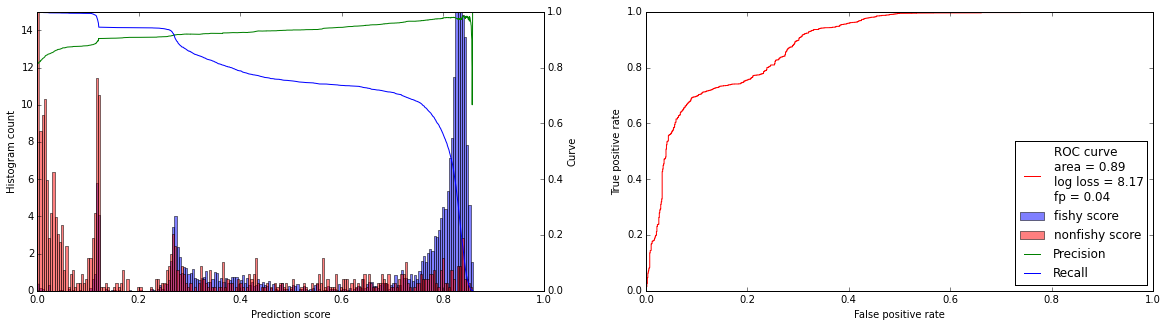

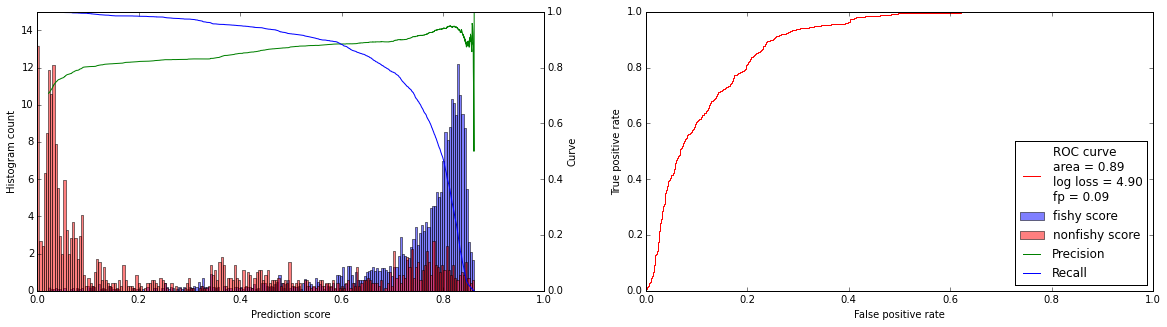

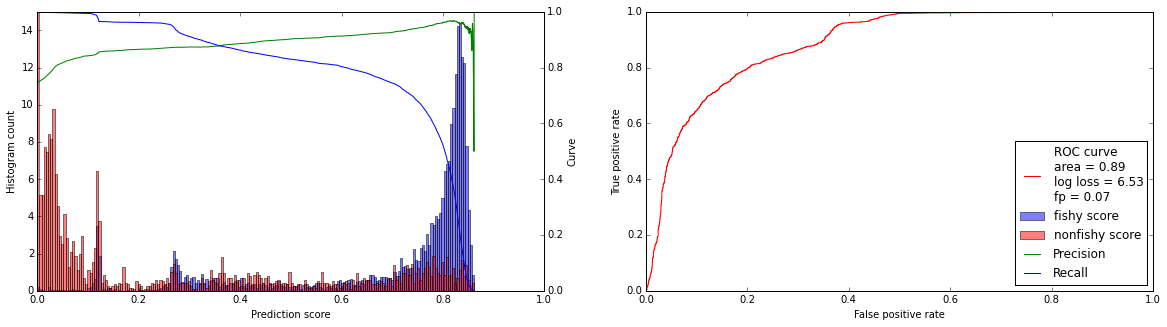

In [16]:
from vessel_scoring.logistic_model import LogisticModel
from vessel_scoring.evaluate_model import evaluate_model, train_model, compare_models

model = LogisticModel(cross=3, order=4, random_state=4321, windows=[86400])

# First train using Alex's data and then evaluate using both Kristina and Alex's data.
train_model(model, _train)

display(HTML("<h1>Train Using Alex's Data</h1>"))

evaluate_model(model, xtest, name="Evaluation Using Kristina's Data")

evaluate_model(model, _xtest, name="Evaluation Using Alex's Data")

evaluate_model(model, joint_test, name="Evaluation Using Mixed Data")

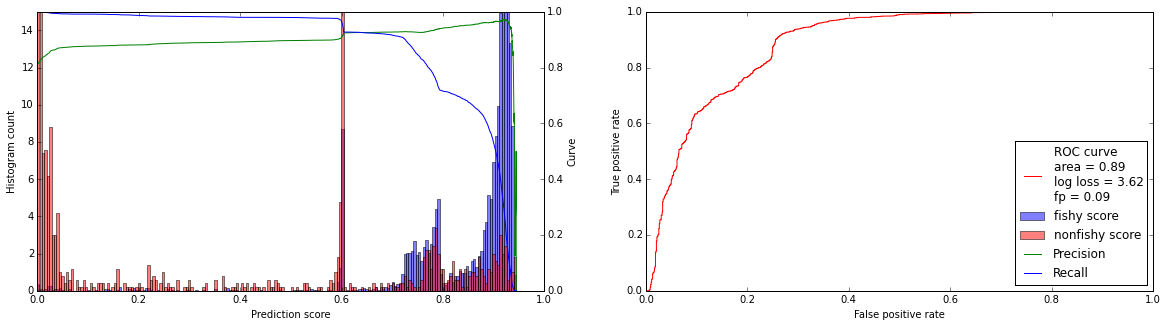

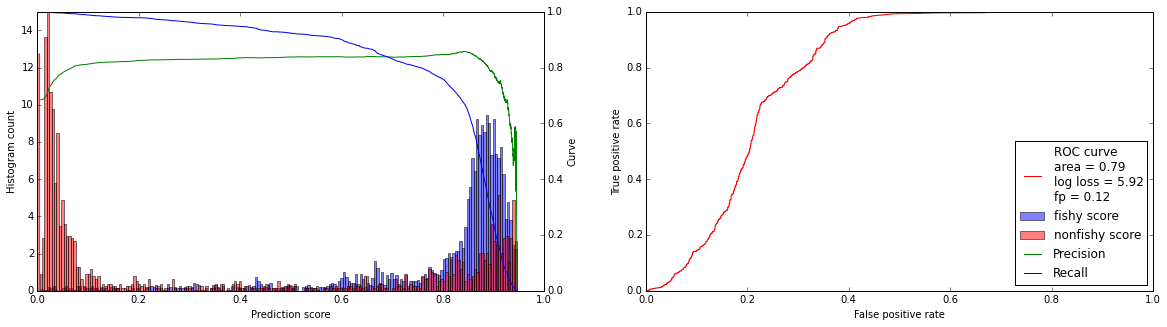

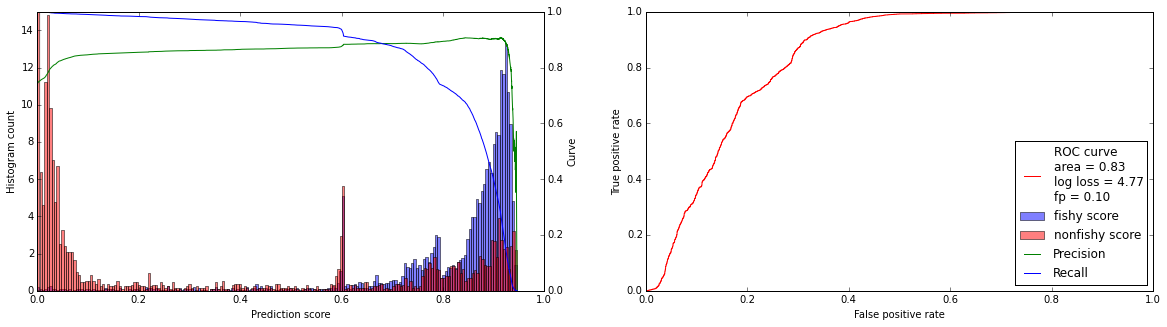

In [17]:
# Now train using Kristina's data and then evaluate using both Kristina and Alex's data.
train_model(model, train)

display(HTML("<h1>Train Using Kristina's Data</h1>"))

evaluate_model(model, xtest, name="Evaluation Using Kristina's Data")

evaluate_model(model, _xtest, name="Evaluation Using Alex's Data")

evaluate_model(model, joint_test, name="Evaluation Using Mixed Data")

# Is there any overlap between MMSI?

In [5]:
overlap = set(x['mmsi']) & set(_x['mmsi'])
print overlap

set([431154000.0])


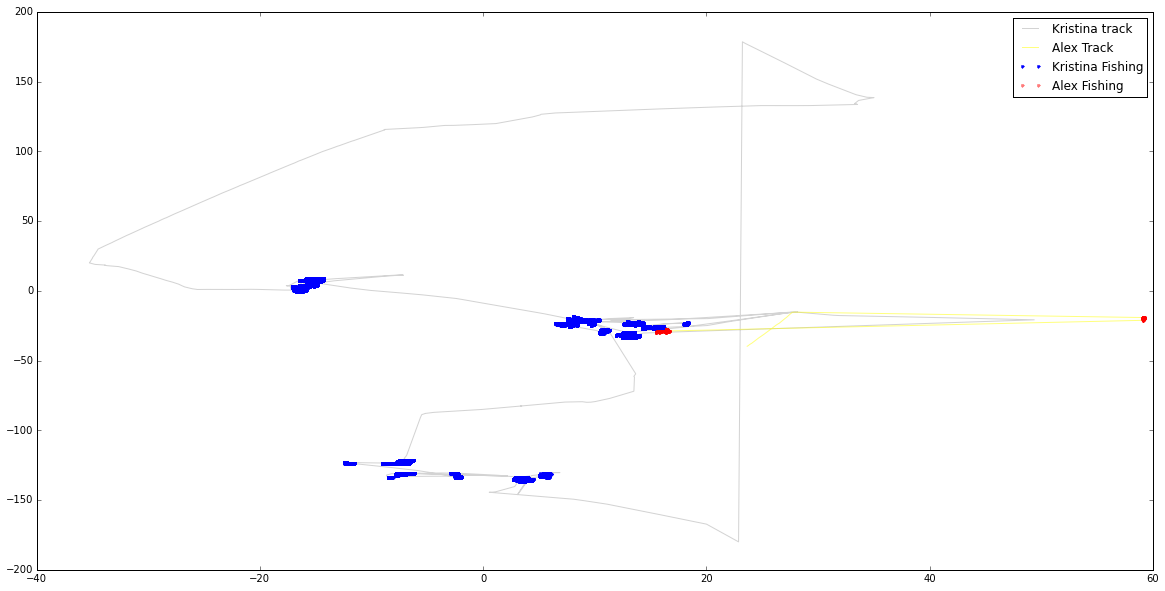

In [6]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

[m] = overlap

x_m = x[x['mmsi'] == m]
_x_m = _x[_x['mmsi'] == m]

plt.plot(x_m['lat'], x_m['lon'], 'lightgrey', label='Kristina track')
plt.plot(_x_m['lat'], _x_m['lon'], 'yellow', alpha=0.5, label='Alex Track')

f_x_m = fishy(x_m)
_f_x_m = fishy(_x_m)

plt.plot(f_x_m['lat'], f_x_m['lon'], 'b.', label='Kristina Fishing')
plt.plot(_f_x_m['lat'], _f_x_m['lon'], 'r.', alpha=0.5, label='Alex Fishing')

_ = plt.legend()

There is very little overlap betwen these two MMSI. Where they overlap they mostly agree, but one fishing area on Alex's is not on Kristina's.

# Where are the vessels

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


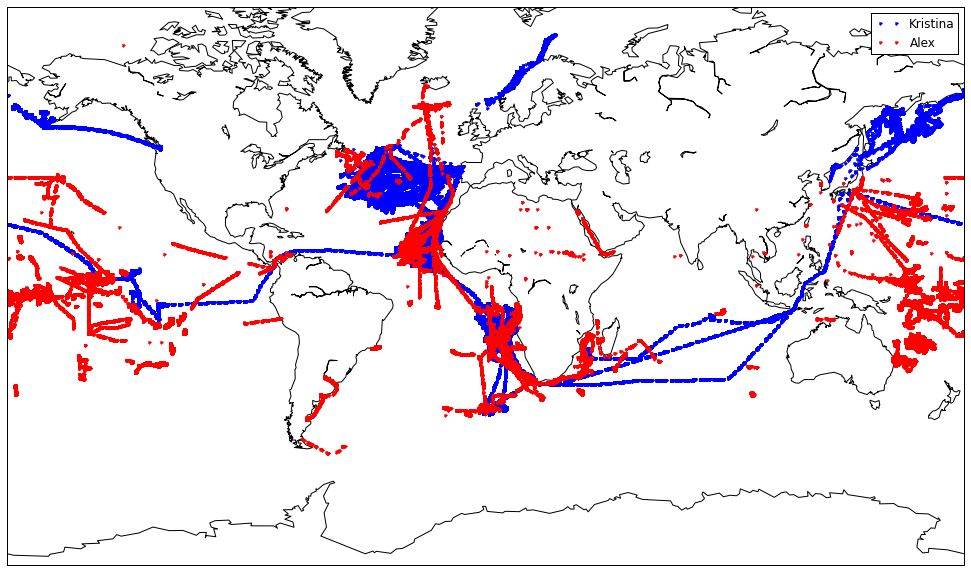

In [7]:
from mpl_toolkits.basemap import Basemap, addcyclic

f, a = plt.subplots(1, 1, figsize=(20, 10))

m = Basemap(llcrnrlon=-180, llcrnrlat=-80, urcrnrlon=180, urcrnrlat=80, projection='mill')
m.drawcoastlines()

# Kristina's vessels in blue
xx, xy = m(x['lon'], x['lat'])    
m.plot(xx, xy, 'b.', label="Kristina")    

# Alex's vessels in red
xx, xy = m(_x['lon'], _x['lat'])    
m.plot(xx, xy, 'r.', label="Alex") 

plt.legend()
plt.show()


# Diferences between the datasets
How does the two labeled datasets differ in their labeleing? Alex only has labeled data for longliners, so that's what we'll compare:

norm_inv_speed is:

    norm_inv_speed = (1 - speed / 17.0) if (speed < 17) else 0
    
Egil uses this as a predictor, but for people not working on the models directly,
the speed is probably more informative.

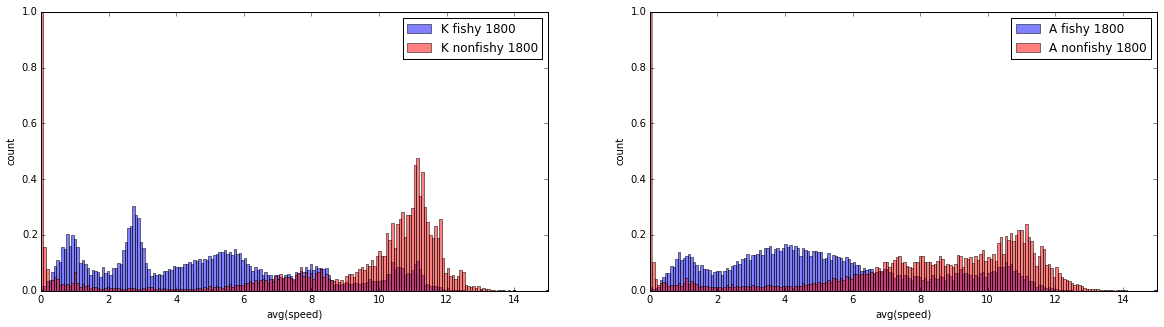

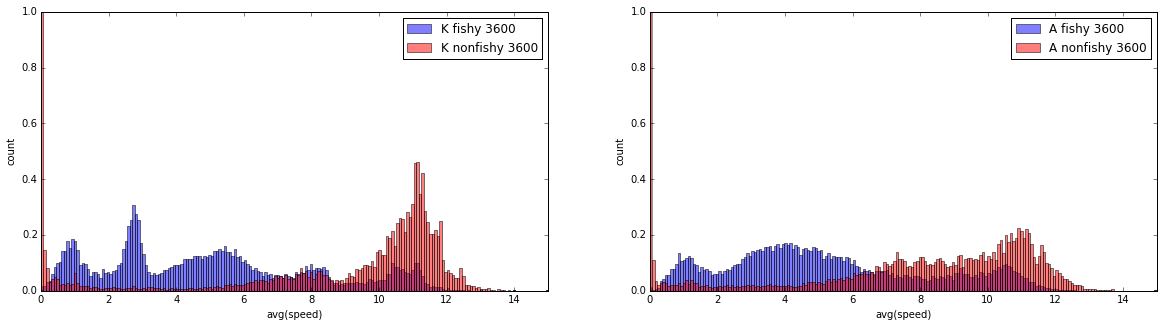

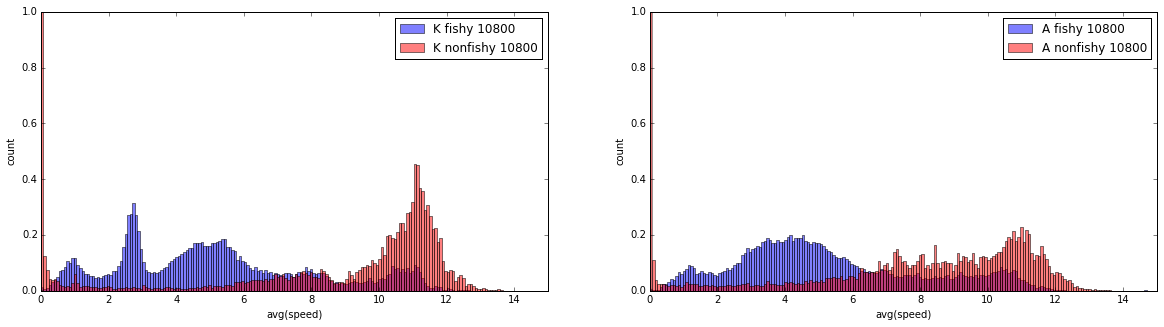

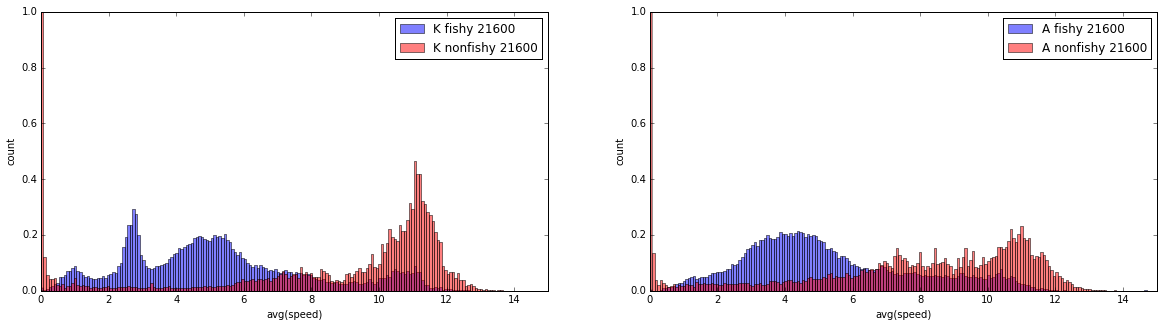

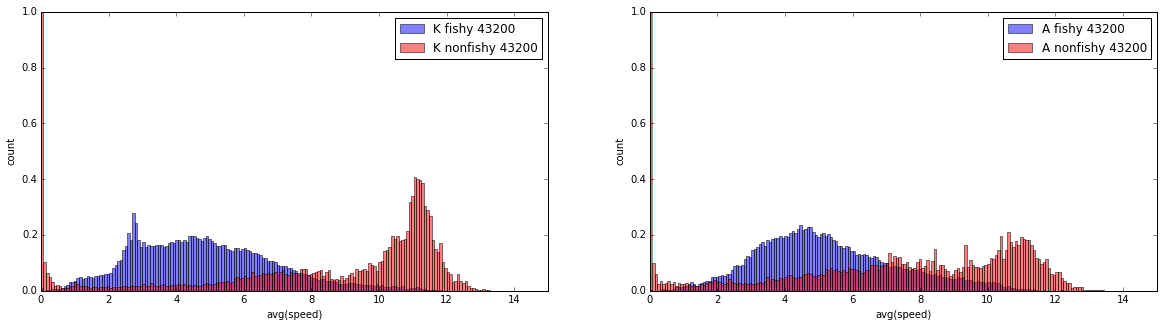

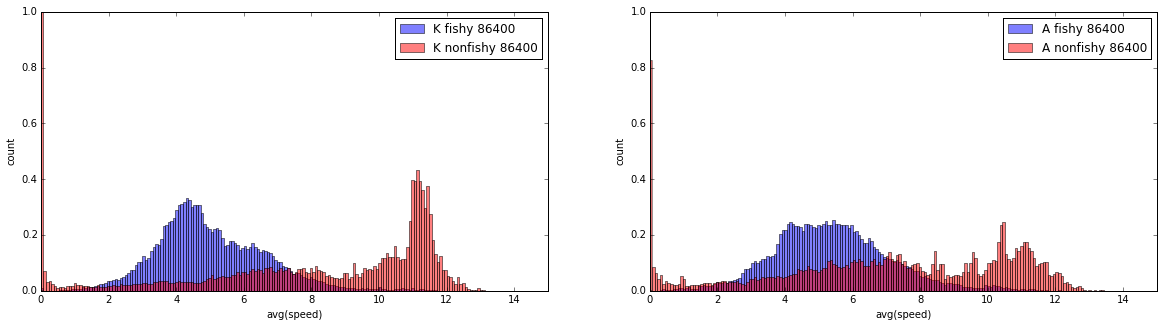

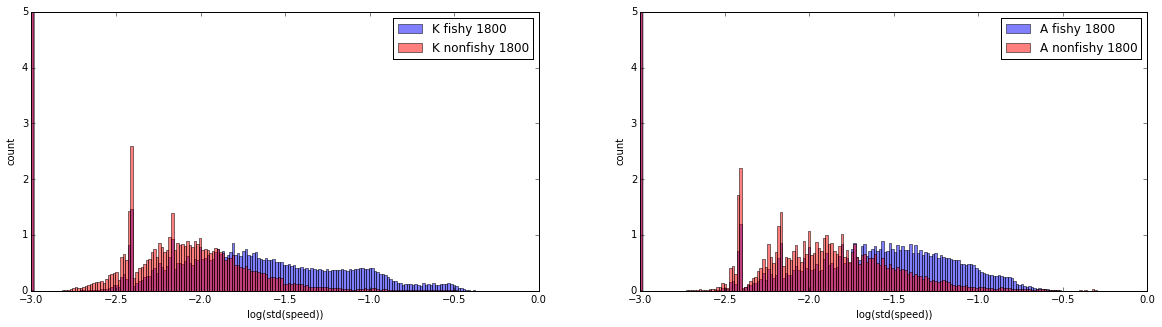

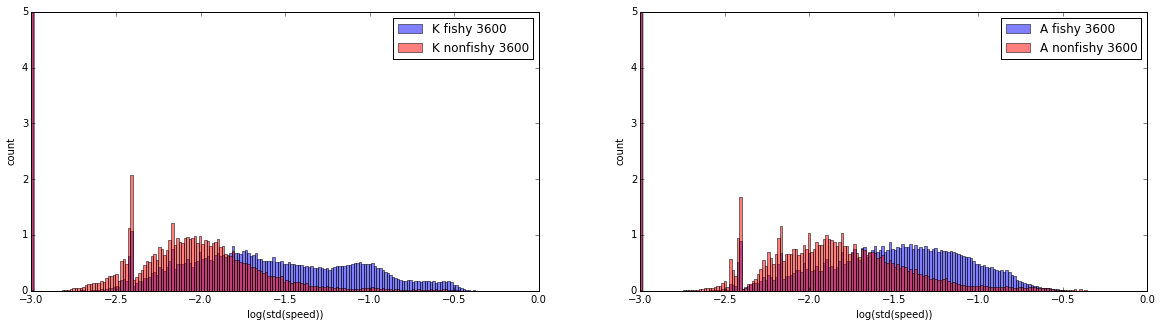

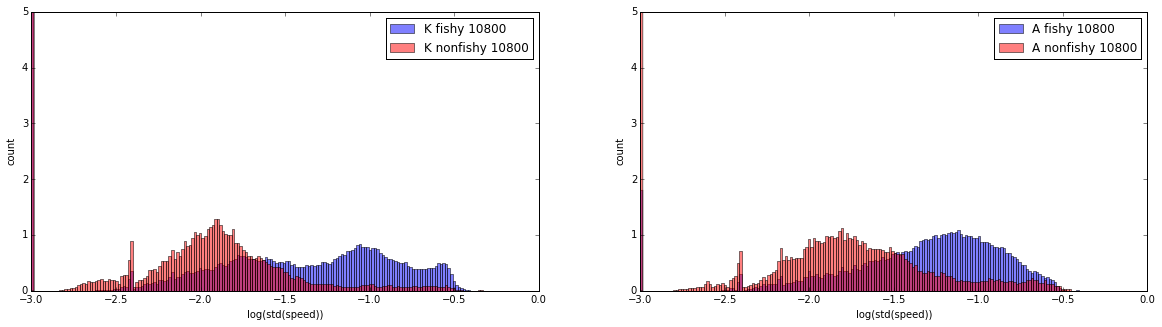

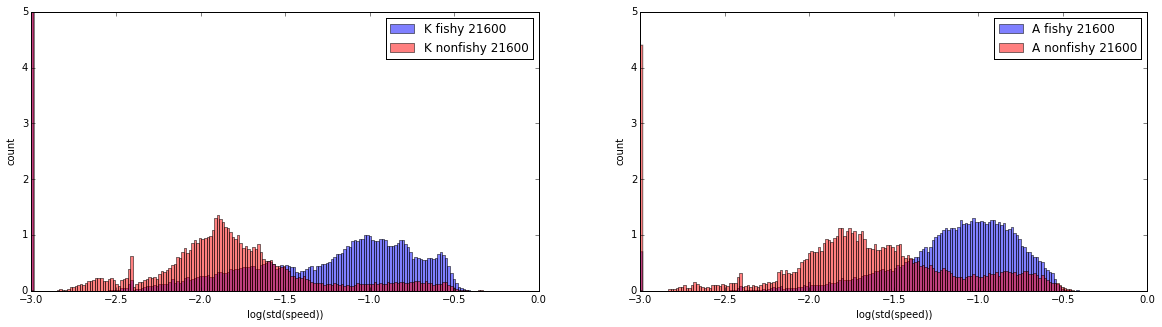

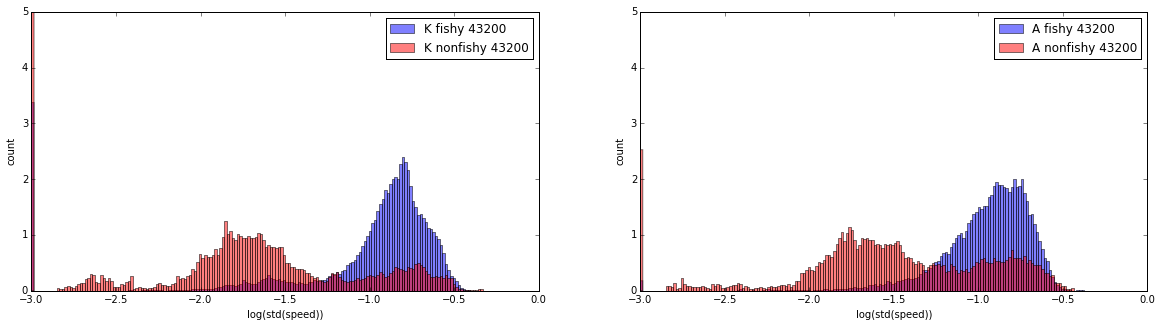

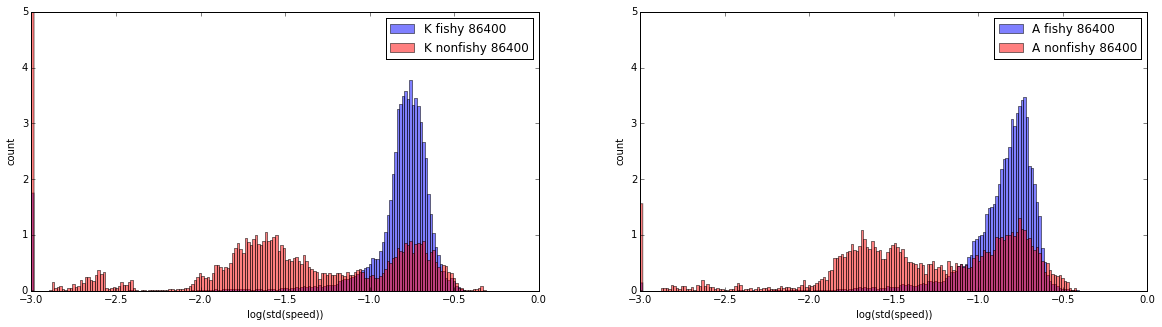

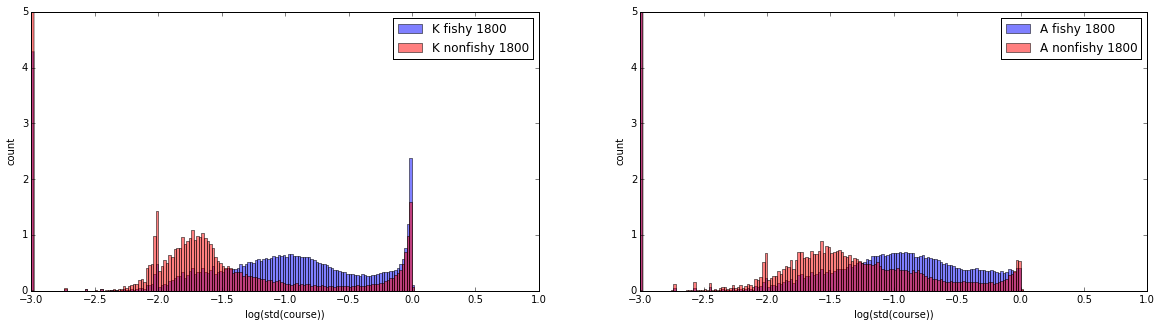

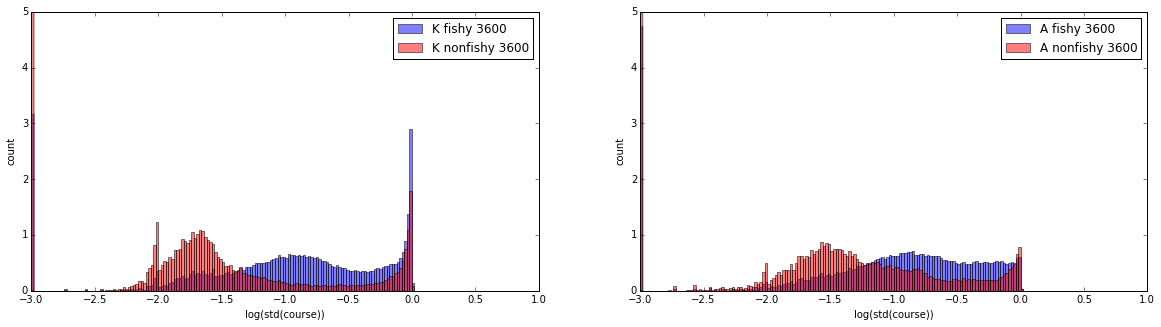

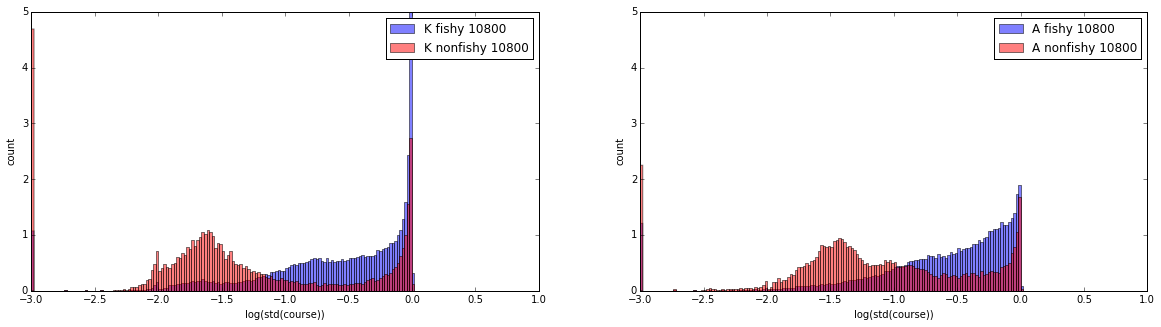

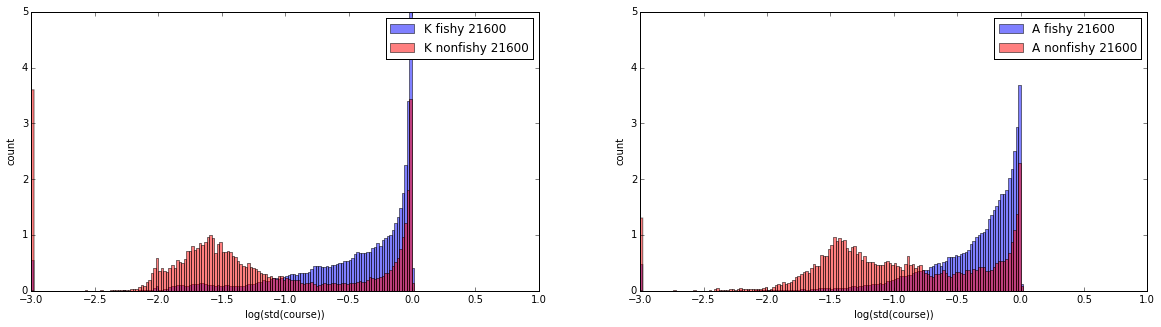

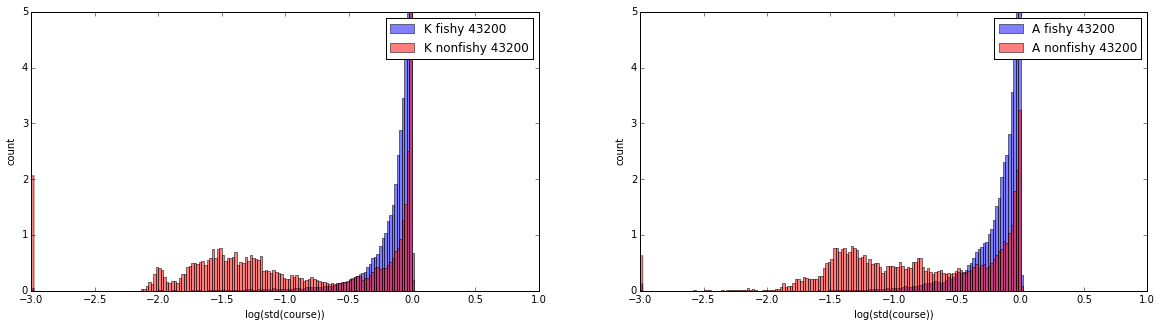

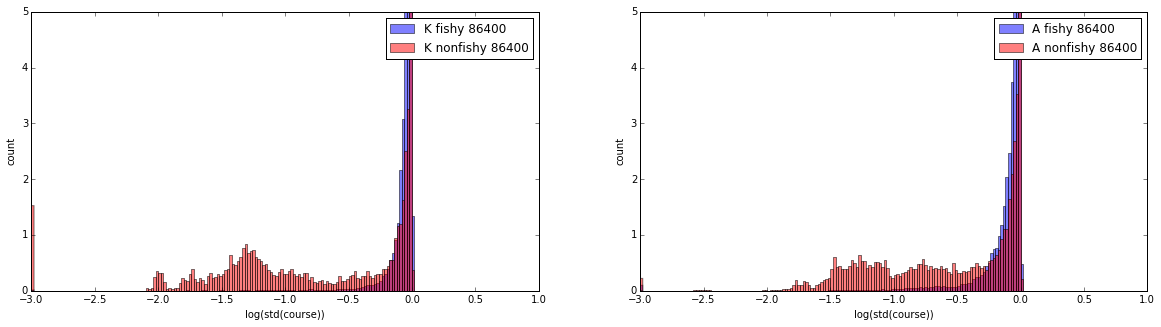

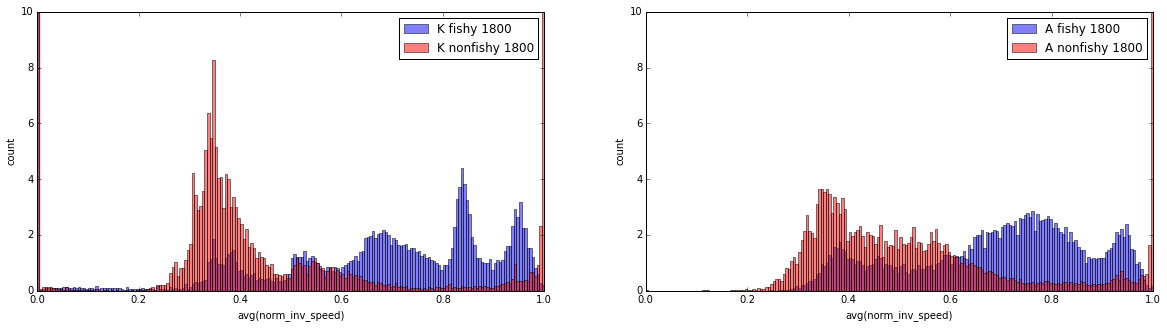

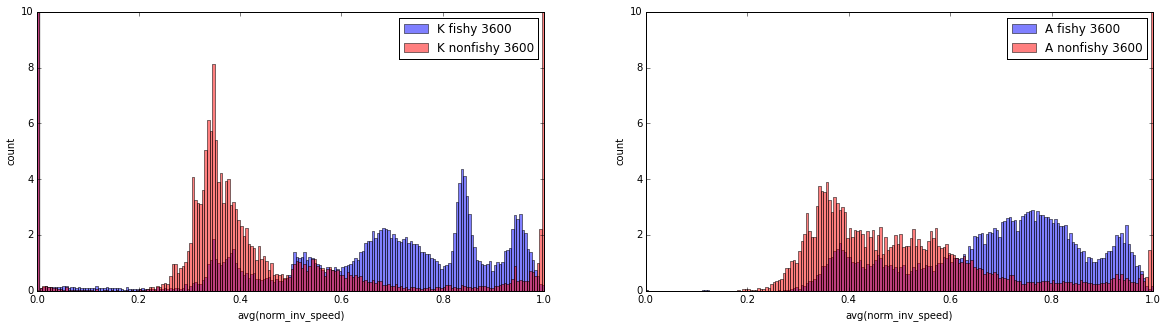

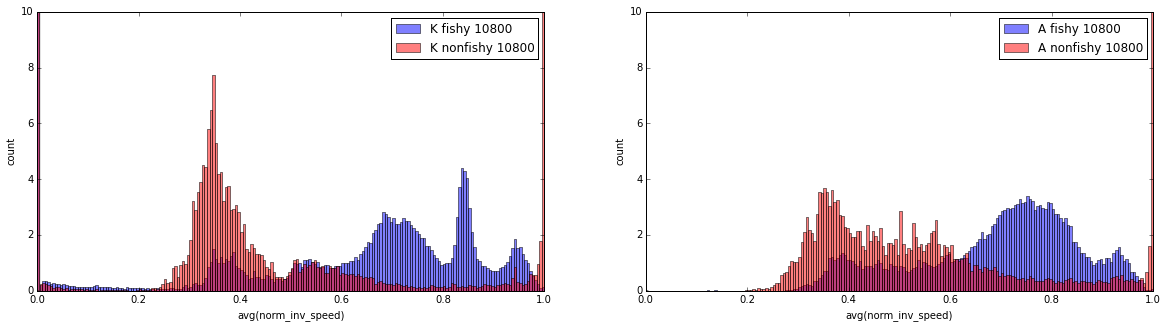

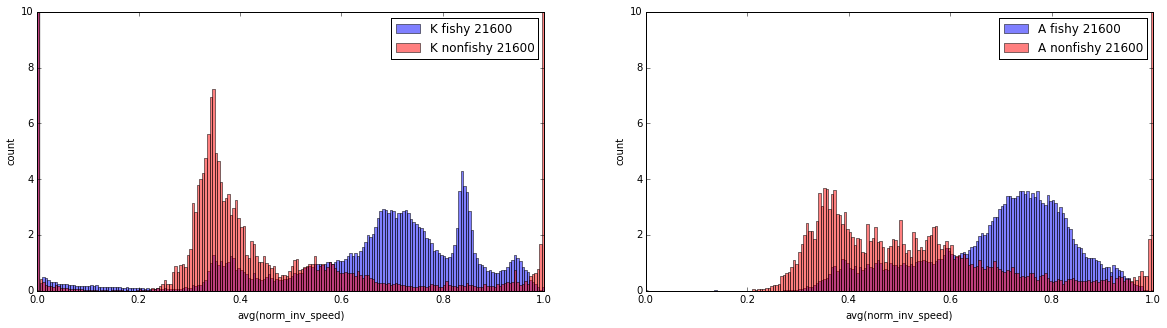

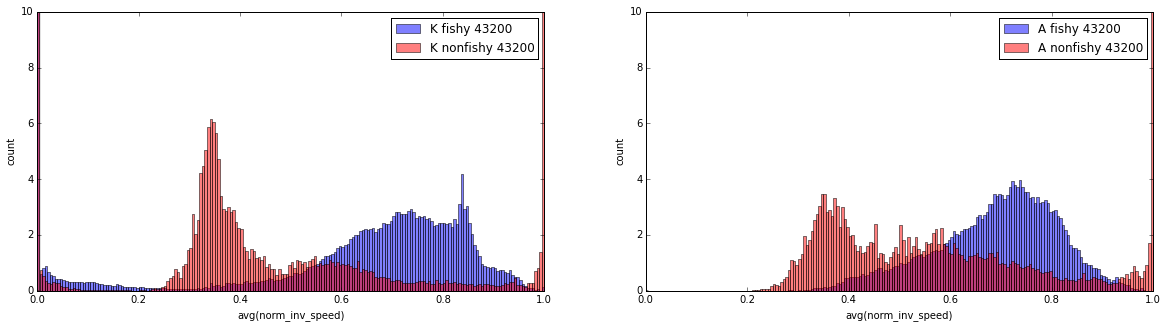

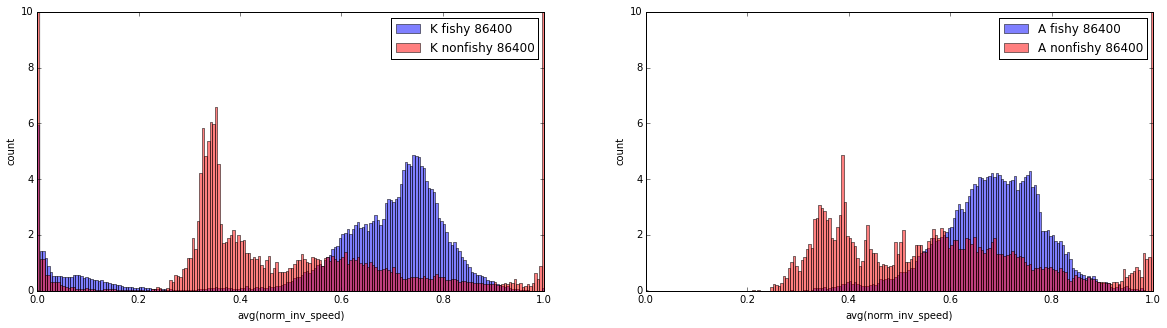

In [14]:
xfishy = fishy(x)
xnonfishy = nonfishy(x)
_xfishy = fishy(_x)
_xnonfishy = nonfishy(_x)
# _xnonfishy = nonfishy(xtest) # Was buggy
for template, name, xlimit, ylimit in [
        ('speedavg_{0}', "avg(speed)", (0,15), (0,1)),
        ('measure_speedstddev_{0}_log', "log(std(speed))", (-3,0), (0,5)),
        ('measure_coursestddev_{0}_log', "log(std(course))", (-3,1), (0,5)),
        ('measure_speedavg_{0}', "avg(norm_inv_speed)", (0,1), (0,10)),
        ]:
    display(HTML("<h1>{0}</h1>".format(name)))
    for window in windows:
        col = template.format(window) if window else template
        plt.figure(figsize=(20,5))
        plt.subplot(1, 2, 1)
        plt.hist(xfishy[col], bins=200, range=xlimit, normed=True, color='b', 
                 alpha=0.5, label="K fishy " + str(window))
        plt.hist(xnonfishy[col], bins=200, range=xlimit, normed=True, color='r', 
                 alpha=0.5, label="K nonfishy " + str(window))
        plt.legend()
        plt.xlabel(name)
        plt.ylabel("count")
        plt.xlim(*xlimit)
        plt.ylim(*ylimit)

        plt.subplot(1, 2, 2)
        plt.hist(_xfishy[col], bins=200, range=xlimit, normed=True, color='b', 
                 alpha=0.5, label="A fishy " + str(window))
        plt.hist(_xnonfishy[col], bins=200, range=xlimit, normed=True, color='r', 
                 alpha=0.5, label="A nonfishy " + str(window))
        plt.legend()
        plt.xlabel(name)
        plt.ylabel("count")
        plt.xlim(*xlimit)
        plt.ylim(*ylimit)
        plt.show()